In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import loadtxt
%matplotlib inline

# read data
df = pd.read_parquet('../data/mbti_1.pqt')
df.head(10)

,label,text,is_valid
0,ISFP,"'He sounds like he likes you, if you really wa...",False
1,INTJ,'I saved a dog's life today in the most cliche...,False
2,INFP,'https://www.youtube.com/watch?time_continue=2...,False
3,ENTP,'Tell me about it!!|||When I apologised for up...,True
4,INTJ,'If you ever meet someone you get along with i...,False
5,INFJ,'https://i.chzbgr.com/completestore/12/9/12/4J...,True
6,ISFP,'I'm lovin' this. The live chat is hilarious. ...,False
7,INFJ,'Not true. I have contacts whom I have contact...,False
8,INFP,The bulk of humanity is just evil.....I want m...,False
9,INTP,"'keep it coming, people this entp interaction ...",True


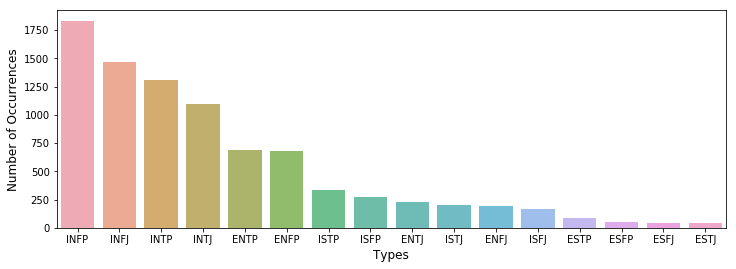

In [2]:
cnt_types = df['label'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

### Add columns for the type Indicators

In [3]:
type_indicators = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

def get_types(row):
    t=row['label']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E incorrect')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S incorrect')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F incorrect')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P incorrect')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

df = df.join(df.apply (lambda row: get_types (row),axis=1))
df.head(5)

,label,text,is_valid,IE,NS,TF,JP
0,ISFP,"'He sounds like he likes you, if you really wa...",False,1,0,0,0
1,INTJ,'I saved a dog's life today in the most cliche...,False,1,1,1,1
2,INFP,'https://www.youtube.com/watch?time_continue=2...,False,1,1,0,0
3,ENTP,'Tell me about it!!|||When I apologised for up...,True,0,1,1,0
4,INTJ,'If you ever meet someone you get along with i...,False,1,1,1,1


In [4]:
print ("Introversion (I) vs  Extroversion (E):\t", df['IE'].value_counts()[0], " / ", df['IE'].value_counts()[1])
print ("Intuition (N) vs Sensing (S):\t\t", df['NS'].value_counts()[0], " / ", df['NS'].value_counts()[1])
print ("Thinking (T) vs Feeling (F):\t\t", df['TF'].value_counts()[0], " / ", df['TF'].value_counts()[1])
print ("Judging (J) vs Perceiving (P):\t\t", df['JP'].value_counts()[0], " / ", df['JP'].value_counts()[1])

Introversion (I) vs  Extroversion (E):	 1999  /  6676
Intuition (N) vs Sensing (S):		 1197  /  7478
Thinking (T) vs Feeling (F):		 4694  /  3981
Judging (J) vs Perceiving (P):		 5241  /  3434


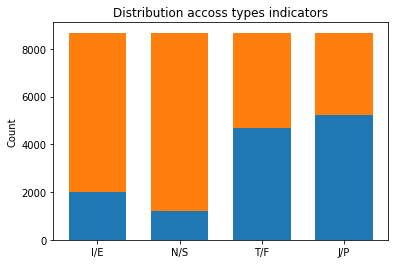

In [5]:
N = 4
but = (df['IE'].value_counts()[0], df['NS'].value_counts()[0], df['TF'].value_counts()[0], df['JP'].value_counts()[0])
top = (df['IE'].value_counts()[1], df['NS'].value_counts()[1], df['TF'].value_counts()[1], df['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
width = 0.7      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))

plt.show()

In [6]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    # transform binary vector to mbti personality
    
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

# Check ...
d = df.head(4)
list_personality_bin = np.array([translate_personality(p) for p in d.label])
print("Binarize MBTI list: \n%s" % list_personality_bin)


Binarize MBTI list: 
[[0 1 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 1 1]]


### Preprocessing posts
* Remove urls 
* Keep only words and put everything lowercase
* Lemmatize each word 
* __Remove MBTI profiles strings. Too many appear in the posts!__

In [7]:
##### Compute list of subject with Type | list of comments 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

# We want to remove these from the psosts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = [x.lower() for x in unique_type_list]


# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

def pre_process_data(data, remove_stop_words=True, remove_mbti_profiles=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    is_valid = []
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].text
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        type_labelized = translate_personality(row[1].label)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)

    return list_posts, list_personality

In [8]:
train = df[df['is_valid'] == False]
test = df[df['is_valid'] == True]

X_train, y_train  = pre_process_data(train, remove_stop_words=True)
X_test, y_test  = pre_process_data(test, remove_stop_words=True)
print("Num posts and personalities train: ",  X_train.shape, y_train.shape)
print("Num posts and personalities test: ",  X_test.shape, y_test.shape)

1 of 6940 rows
500 of 6940 rows
1000 of 6940 rows
1500 of 6940 rows
2000 of 6940 rows
2500 of 6940 rows
3000 of 6940 rows
3500 of 6940 rows
4000 of 6940 rows
4500 of 6940 rows
5000 of 6940 rows
5500 of 6940 rows
6000 of 6940 rows
6500 of 6940 rows
6940 of 6940 rows
1 of 1735 rows
500 of 1735 rows
1000 of 1735 rows
1500 of 1735 rows
1735 of 1735 rows
Num posts and personalities train:  (6940,) (6940, 4)
Num posts and personalities test:  (1735,) (1735, 4)


In [9]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)